# Detect ROIs to estimate TSR within.
This notebook shows the method used, run `find_ROI.py` to do the same for all slides.

In [207]:
import Abed_utils
from wsi import WholeSlideDataset

import os

import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ImageDraw import ImageDraw

from glob import glob

In [27]:
wsi = WholeSlideDataset(Abed_utils.TEST_SLIDE_PATH)
preds = np.load(
                os.path.join(Abed_utils.OUTPUT_ROOT, 'wsi', os.path.basename(wsi.path), 'seg_dino_imagenet_100ep_KNN.npy'),
                allow_pickle=True).item()
pd.value_counts(preds['classification'])

7.0    25580
5.0    22502
8.0    17915
0.0    17142
1.0    11868
6.0     9137
4.0     5857
2.0     2980
3.0     1626
dtype: int64

In [28]:
pred_patch_size = int(preds['metadata'][0,-2])
if (preds['metadata'][:,-2] == pred_patch_size).all():
    print(f'Each patch covers {pred_patch_size}px^2 of the WSI')
else:
    raise RuntimeError('Not all patches are of the same size!')


Each patch covers 448px^2 of the WSI


In [33]:
downsample_factor = 1

patch_size = wsi.mpp * downsample_factor *  pred_patch_size# [um/patch]
diameter = round(2500 / patch_size) # [patch]
search_radius = round(500 / patch_size) # [patch]

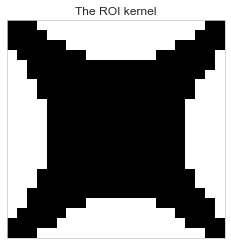

Kernel size: (22, 22)


In [195]:
p = 0.15 # Percentage of the circle to show at each side

kernel = Image.new('1', (diameter, diameter), 0)
draw = ImageDraw(kernel)
draw.ellipse(xy=[((p-1)*diameter, 0), (p*diameter, diameter)], fill=1)
draw.ellipse(xy=[((1-p)*diameter, 0), ((2-p)*diameter, diameter)], fill=1)
draw.ellipse(xy=[(0, (p-1)*diameter), (diameter, p*diameter)], fill=1)
draw.ellipse(xy=[(0, (1-p)*diameter), (diameter, (2-p)*diameter)], fill=1)

# kernel = kernel.convert('F')
# _, ax = plt.subplots(1,1, figsize=(7,7))
plt.imshow(kernel)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.title('The ROI kernel')
plt.show()
print(f'Kernel size: {kernel.size}')

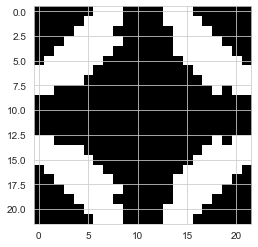

In [198]:
plt.imshow(kernel.rotate(45), resample=Image.NEAREST)
plt.show()

## Build the prediction tensor

In [174]:
pred_tensor = torch.zeros(wsi.s.dimensions[1]//(pred_patch_size*downsample_factor), wsi.s.dimensions[0]//(pred_patch_size*downsample_factor), dtype=torch.uint8)
print(f'Prediction tensor is of size {pred_tensor.shape}')

Prediction tensor is of size torch.Size([177, 256])


In [175]:
metadata = preds['metadata'].astype(int)
df = pd.DataFrame(data=metadata[:,2:8], columns=preds['metadata_labels'][2:8])
df = df//(pred_patch_size*downsample_factor)
df['pred'] = preds['classification'].astype(int)
df.head()

,tx,ty,cx,cy,bx,by,pred
0,101,0,101,0,102,1,1
1,101,0,102,0,102,1,1
2,102,0,102,0,103,1,1
3,102,0,103,0,103,1,1
4,103,0,103,0,104,1,1


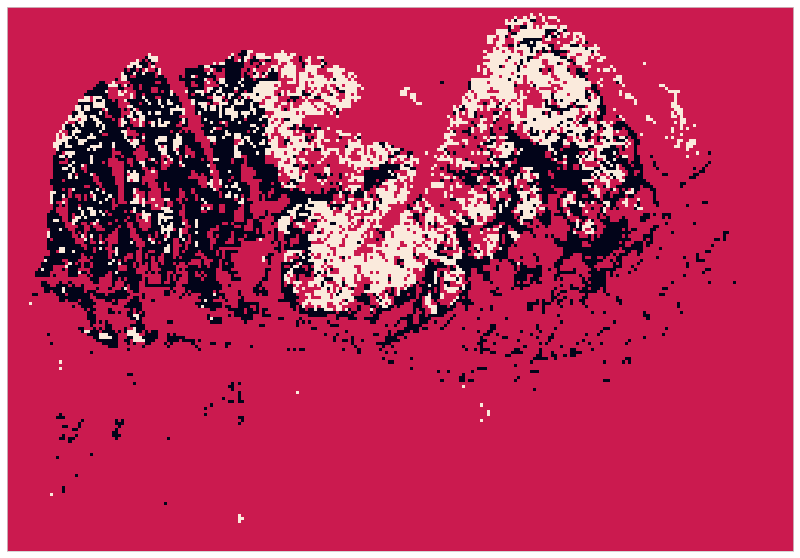

In [211]:
for coords, group in df.groupby(by=['cx', 'cy']):
    pred_tensor[coords[::-1]] = group.pred.mode()[0]

pred_tensor = pred_tensor.float()
for i in range(7):
    pred_tensor[pred_tensor == i] = 0
pred_tensor[pred_tensor == 7] = -1
pred_tensor[pred_tensor == 8] = 1
_, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(pred_tensor)
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

Kernel: tensor([-1.,  1.]), torch.Size([1, 1, 22, 22]), torch.float32
Input: tensor([-1.,  0.,  1.]), torch.Size([177, 256]), torch.float32


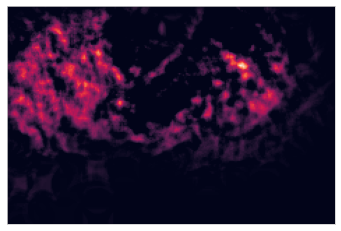

In [212]:
k = T.ToTensor()(kernel).unsqueeze(0)
# print(pred_tensor.shape)
k = (2 * k -1)
print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
# print(k.shape)
print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
hmap = F.conv2d(input=pred_tensor.unsqueeze(0), weight=k, stride=(1,), padding='valid', dilation=(1,))[0,:,:]
plt.imshow(hmap.relu())
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

## With rotations:

C:\Users\Zace VR\AppData\Local\Temp\ipykernel_9252\3951287313.py:17: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')


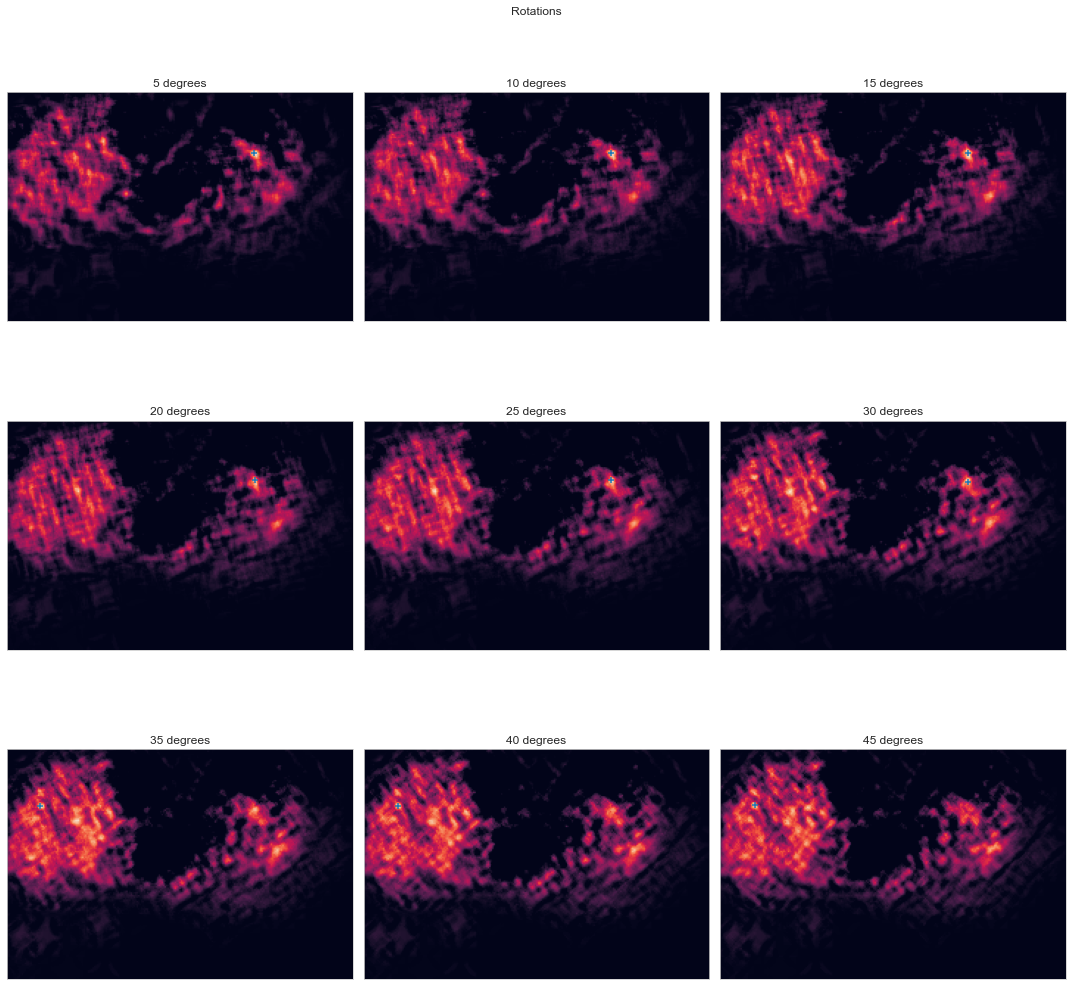

In [213]:
rotations = range(5,50,5)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Rotations')
for i, rot in enumerate(rotations):
    k = kernel.rotate(rot)
    k = T.ToTensor()(k).unsqueeze(0)
    # print(pred_tensor.shape)
    k = (2 * k -1)
    # print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
    # print(k.shape)
    # print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
    hmap = F.conv2d(input=pred_tensor.unsqueeze(0).float(), weight=k, stride=(1,), padding='valid', dilation=(1,))[0,:,:]

    ax = axs[i//3, i%3]
    ax.imshow(hmap.relu())
    idx = hmap.argmax()
    ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')
    ax.set_title(f'{rot} degrees')
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [208]:
hmap.flatten().topk(5)

torch.return_types.topk(
values=tensor([156., 155., 143., 140., 139.]),
indices=tensor([8718, 8953, 9224, 8954, 9189]))

## Finding the 5 most probable ROIs from all rotation possibilities

In [214]:
rotations = range(0,50,5)
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Rotations')
vals = []
xs, ys = [],  []
with torch.no_grad():
    for i, rot in enumerate(rotations):
        k = kernel.rotate(rot)
        k = T.ToTensor()(k).unsqueeze(0)/255
        # print(pred_tensor.shape)
        k = (2 * k -1)
        # print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
        # print(k.shape)
        # print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
        hmap = F.conv2d(input=pred_tensor.unsqueeze(0).float(), weight=k, stride=(1,), padding='valid', dilation=(1,))[0,:,:]

        v, idxs = hmap.flatten().topk(1)
        x, y = idxs%hmap.shape[1], idxs//hmap.shape[1]
        xs.extend(x)
        ys.extend(y)
        vals.extend(v)


        # ax = axs[i//3, i%3]
        # ax.imshow(hmap.relu())
        # ax.set_title(f'{rot} degrees')
        # ax.grid(None)
        # ax.set_xticks([])
        # ax.set_yticks([])
coords = pd.DataFrame(data=list(zip(xs, ys, vals)), columns=['x', 'y', 'value'])
coords = coords.applymap(lambda x: x.item())
coords[['x', 'y']] *= pred_patch_size*downsample_factor
coords.head()

C:\Users\Zace VR\AppData\Local\Temp\ipykernel_9252\3414023301.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x, y = idxs%hmap.shape[1], idxs//hmap.shape[1]


,x,y,value
0,24192,22400,324.909821
1,24192,22400,324.980408
2,24192,22400,325.050995
3,24192,22400,325.066681
4,24192,22400,325.058838


In [210]:
print(coords.sort_values(by='value', ascending=False).head(20))

       x      y       value
5  24192  22400  325.074524
3  24192  22400  325.066681
4  24192  22400  325.058838
7  24192  22400  325.058838
2  24192  22400  325.050995
8  24192  22400  325.019623
6  24192  22400  324.996094
9  24192  22400  324.988251
1  24192  22400  324.980408
0  24192  22400  324.909821


In [184]:
(coords*wsi.mpp).sort_values(by='value', ascending=False)

,x,y,value
25,6096.384,5644.800,81.918780
15,6096.384,5644.800,81.916804
35,6096.384,5644.800,81.914827
20,6096.384,5644.800,81.914827
10,6096.384,5644.800,81.912851
40,6096.384,5644.800,81.904945
30,6096.384,5644.800,81.899016
45,6096.384,5644.800,81.897039
5,6096.384,5644.800,81.895063
0,6096.384,5644.800,81.877275


In [172]:
glob(os.path.join(Abed_utils.BERN_COHORT_ROOT, '*', '*.mrxs'))

['D:\\self_supervised_pathology\\datasets\\WSI\\bern_cohort_clean\\1\\001b_B2005.30530_C_HE.mrxs',
 'D:\\self_supervised_pathology\\datasets\\WSI\\bern_cohort_clean\\352\\352b_B2005.5775_F_HE.mrxs',
 'D:\\self_supervised_pathology\\datasets\\WSI\\bern_cohort_clean\\565\\565c_B2012.15587_B_HE.mrxs']

In [167]:
Abed_utils.BERN_COHORT_ROOT + '*.mrxs'

'D:\\self_supervised_pathology\\datasets\\WSI\\bern_cohort_clean*.mrxs'